In this notebook, I compare the quality of synthetic data produced by the following vendors: Mostly.ai, Synthesized.io, Gretel, YData.ai and open source SDV (the lite version). The synthetizations from different vendors are stored in the csv file <code>insurance_compare.csv</code>. The first column indicates the vendor; the real data, also in this file, is labeled as "Real". I performed the test on 3 datasets. In this notebook, I focus on the insurance data set. More details can be found on my GitHub repository, <a href="https://github.com/VincentGranville/Main/tree/main">here</a>. 

The comparison method using holdhout is in a separe program, in the same GitHub folder: in that framework, the real data is labeled as "Validation" instead of "Real"; it is a subset of the real data not used for training the synthesizer.

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF

Reading the data. I ignore the categorical feature "Region" and focus on continuous or ordinal ones. To compute the correlation between categorical variables, one can use Cramer's V correlation. 

In [2]:
dataset = 'insurance_compare.csv'
url = "https://raw.githubusercontent.com/VincentGranville/Main/main/" + dataset ## insurance_compare.csv"
df = pd.read_csv(url)
# df = pd.read_csv(dataset)
if dataset == 'insurance_compare.csv':
    df = df.drop('region', axis=1)
    df = df.dropna(axis='columns')
print(df.head())

   Data   age  sex     bmi  children  smoker   charges
0  Real  19.0    1  27.900       0.0       1  16884.92
1  Real  18.0    0  33.770       1.0       0   1725.55
2  Real  28.0    0  33.000       3.0       0   4449.46
3  Real  33.0    0  22.705       0.0       0  21984.47
4  Real  32.0    0  28.880       0.0       0   3866.86


Storing the real data as a separate dataset. 

In [3]:
data_real = df.loc[df['Data'] == 'Real']
data_real = data_real.drop('Data', axis=1)
data_real = data_real.to_numpy()
print(data_real)

[[1.900000e+01 1.000000e+00 2.790000e+01 0.000000e+00 1.000000e+00
  1.688492e+04]
 [1.800000e+01 0.000000e+00 3.377000e+01 1.000000e+00 0.000000e+00
  1.725550e+03]
 [2.800000e+01 0.000000e+00 3.300000e+01 3.000000e+00 0.000000e+00
  4.449460e+03]
 ...
 [1.800000e+01 1.000000e+00 3.685000e+01 0.000000e+00 0.000000e+00
  1.629830e+03]
 [2.100000e+01 1.000000e+00 2.580000e+01 0.000000e+00 0.000000e+00
  2.007950e+03]
 [6.100000e+01 1.000000e+00 2.907000e+01 0.000000e+00 1.000000e+00
  2.914136e+04]]


Computing the correlation matrix (cross-correlations between features) on the real data. The goal is to compare this matrix with those obtained on the various synthetizations, to assess how well cross-correlations present in the real data, are replicated by the various vendors.

In [4]:
r_corr = np.corrcoef(data_real.T) # need to transpose the data to make sense
print(r_corr)

[[ 1.          0.02085587  0.10927188  0.042469   -0.02501875  0.29900819]
 [ 0.02085587  1.         -0.04637115 -0.01716298 -0.07618482 -0.05729207]
 [ 0.10927188 -0.04637115  1.          0.0127589   0.00375043  0.19834098]
 [ 0.042469   -0.01716298  0.0127589   1.          0.00767312  0.06799823]
 [-0.02501875 -0.07618482  0.00375043  0.00767312  1.          0.78725143]
 [ 0.29900819 -0.05729207  0.19834098  0.06799823  0.78725143  1.        ]]


Removing the real data (now stored separately) from the data frame. Checking what data is left, that is, the list of vendors. To each vendor corresponds a synthetization. All have the same number of generated observations, which matches the number in the real data.

In [5]:
ltests = df.Data.unique().tolist()
popped_item = ltests.pop(0)   # remove real data from the tests
print(ltests)

['YData1', 'YData2', 'Gretel', 'SDV', 'Synthesize.io', 'VG_Copula', 'Mostly.ai']


In the following loop, a <code>test</code> represents a vendor. Ignore VG_copula, which is one of my home-made synthetizations: I used a different copula for each group, making the comparison unfair. The following metrics are computed to assess the quality of the synthetization: 
<ul>
<li> Correlation distances in absolute value (between correlations measured on real data, and correlations measured on the synthetization produced by the vendor <code>test</code>). The printed output, for each vendor, is aggregated over all feature  pairs. The aggregated statistics are average and max.
<li> Kolmogorov-Smirnov distance between empirical distribution, for each feature and each vendor. The printed output, for each vendor, is aggregated over all features. The aggregated statistics are average and max. 
</ul>
The first column in the printed output is the dataset used in the test, in this case the insurance dataset. Ignore the last field <code>out_of_range</code>. It is equal to zero, unless the synthetization contains values outside the observed range in the real data.

For the 4 evaluation metrics of interest, a value close to 0 (the minimum) means that the synthetization is very faithful. A value close to 1 means that the quality is very poor. For YData, I did two runs. Use YData1 for fair comparison. 

In [6]:
for test in ltests:

    data_test = df.loc[df['Data'] == test]
    data_test = data_test.drop('Data', axis=1)
    data_test = data_test.to_numpy()
    t_corr = np.corrcoef(data_test.T) 
    delta = np.abs(t_corr - r_corr)
    dim = delta.shape[0]   # number of features
  
    ks = np.zeros(dim)
    out_of_range = 0
    for idx in range(dim):
        dr = data_real[:,idx]
        dt = data_test[:,idx]
        stats = ks_2samp(dr, dt)
        ks[idx] = stats.statistic
        if np.min(dt) < np.min(dr) or np.max(dt) > np.max(dr):
            out_of_range = 1
    str = "%20s %14s %8.6f %8.6f %8.6f %8.6f %1d" % (dataset, test, np.mean(delta), 
              np.max(delta), np.mean(ks), np.max(ks), out_of_range)
    print(str)

insurance_compare.csv         YData1 0.015844 0.051774 0.020227 0.030059 0
insurance_compare.csv         YData2 0.017100 0.052157 0.022297 0.028401 0
insurance_compare.csv         Gretel 0.021085 0.092606 0.040011 0.086254 0
insurance_compare.csv            SDV 0.033703 0.350682 0.093176 0.213358 0
insurance_compare.csv  Synthesize.io 0.025702 0.070506 0.025870 0.040396 0
insurance_compare.csv      VG_Copula 0.013471 0.049100 0.016442 0.032885 0
insurance_compare.csv      Mostly.ai 0.017264 0.057882 0.023169 0.041854 0


Below is a function to produce the scatterplots. There will be 2 x 3 scatterplots in the end, displayed in 2 rows and 3 columns: one per vendor, as well as one for the real data. The selected features chosen for the scatterplots are "age" and "charges", as they exhibit some unusual patterns and inter-dependency structure, that many vendors fail to identify and replicate. Again, <code>test</code> represents the vendor.

In [7]:
def vg_scatter(df, test, counter):

    # customized plots, insurance data 
    # one of 6 plots, subplot position based on counter

    data_plot = df.loc[df['Data'] == test]
    x = data_plot[['age']].to_numpy()
    y = data_plot[['charges']].to_numpy()
    plt.subplot(2, 3, counter)
    plt.scatter(x, y, s = 0.1, c ="blue")
    plt.xlabel(test, fontsize = 7)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(0,70000)
    plt.xlim(18,64)
    return()

Same for histograms, here to illustrate the bimodal distribution for "charges". 

In [8]:
def vg_histo(df, test, counter):

    # customized plots, insurance data 
    # one of 6 plots, subplot position based on counter

    data_plot = df.loc[df['Data'] == test]
    y = data_plot[['charges']].to_numpy()
    plt.subplot(2, 3, counter)
    binBoundaries = np.linspace(0, 70000, 30)
    plt.hist(y, bins=binBoundaries, color='white', align='mid',edgecolor='red',
              linewidth = 0.3) 
    plt.xlabel(test, fontsize = 7)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0,70000)
    plt.ylim(0, 250)
    return()

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 0.3

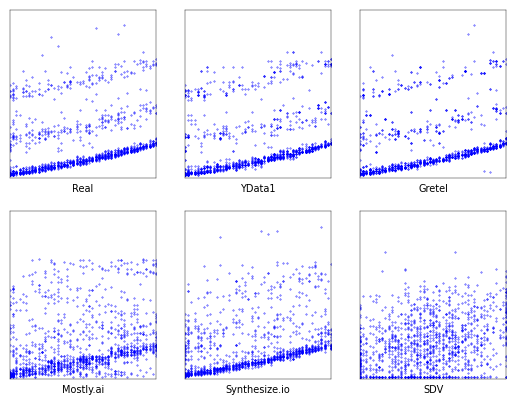

In [10]:
vg_scatter(df, 'Real', 1)
vg_scatter(df, 'YData1', 2)
vg_scatter(df, 'Gretel', 3)
vg_scatter(df, 'Mostly.ai', 4)
vg_scatter(df, 'Synthesize.io', 5)
vg_scatter(df, 'SDV', 6)
plt.show()

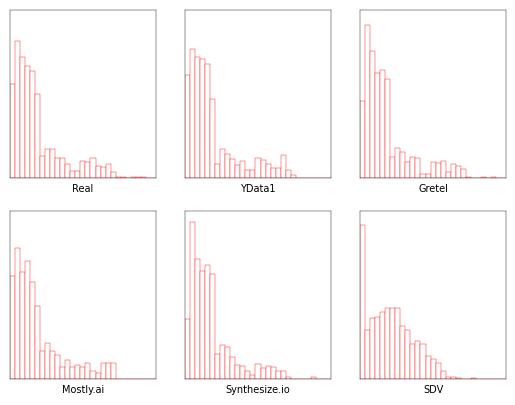

In [11]:
vg_histo(df, 'Real', 1)
vg_histo(df, 'YData1', 2)
vg_histo(df, 'Gretel', 3)
vg_histo(df, 'Mostly.ai', 4)
vg_histo(df, 'Synthesize.io', 5)
vg_histo(df, 'SDV', 6)
plt.show()

YData wins here: this is particularly obvious if you look at the scatterplots. It also scores very well on the other datasets, making it number 1 overall. While Gretel seems to be doing well on the scatterplot, its synthetic data is not properly spread; it is actually performing poorly, if you look at the results in cell 6.